#**Welcome to my Notebook**
Made by Jundan Saiful Haq for DSAI Recruitment.

In this notebook, here, i will do an Airbnb price prediction which is useful for tourists who want to find the best accommodation according to their version and their capabilities.

#1. Import some libraries, read the CSV, and merge the data
Import the common libraries first, and then read each csv files and convert into data frame. And save the test id's so that we can make submission from id's that we save

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [112]:
traindf = pd.read_csv("sample_data/train.csv")
airbnbdf = pd.read_csv("sample_data/airbnb.csv")
hostdf = pd.read_csv("sample_data/host.csv")
commentdf = pd.read_csv("sample_data/comment.csv")
reviewdf = pd.read_csv("sample_data/review.csv")
testdf = pd.read_csv("sample_data/test.csv")

test_id = testdf['id']

Data merge:

In [113]:
train_merged1 = pd.merge(traindf, airbnbdf, on='id', how='left')
train_merged2 = pd.merge(train_merged1, hostdf, on='id', how='left')
train_final = pd.merge(train_merged2, reviewdf, on='id', how='left')

#2. EDA (Exploration Data Analysis)
In this section, we will investigate the data statistics, like five first data (df.head), checking the datatype (df.info), checking missing values (df.isnull().sum()), and check the mean, mode, etc (df.describe()).

In [114]:
print("Rows and columns:")
print(train_final.shape)

print("\n5 first final data: ")
print(train_final.head())
print("\nDatatype: ")
print(train_final.info())

print("\nMissing values: ")
print(train_final.isnull().sum())
print("\nDuplicated data:")
print(train_final.duplicated().sum())

print("Data statistics: ")
train_final.describe()

Rows and columns:
(2954, 45)

5 first final data: 
                    id  price  ... review_scores_value reviews_per_month
0   840338886577189778   88.0  ...                 NaN               NaN
1             25963531   76.0  ...                4.00              0.02
2             15813099  202.0  ...                4.00              0.01
3  1159877277633034540  531.0  ...                3.89              2.43
4   630126688219312259  345.0  ...                 NaN               NaN

[5 rows x 45 columns]

Datatype: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2954 entries, 0 to 2953
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            2954 non-null   int64  
 1   price                         2954 non-null   float64
 2   name                          2954 non-null   object 
 3   description                   2899 non-null   object 
 4   neighborho

,id,price,accommodates,bedrooms,beds,minimum_nights,maximum_nights,longitude,latitude,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_60,availability_90,availability_365,host_total_listings_count,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,2.954000e+03,2954.000000,2954.000000,2711.000000,2264.000000,2954.000000,2954.000000,2954.000000,2954.000000,2953.000000,2953.000000,2953.000000,2953.000000,2954.000000,2954.000000,2954.000000,2954.000000,2954.000000,2954.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1486.000000,1486.000000,1487.000000
mean,6.192201e+17,361.547223,2.638795,1.237182,1.589664,61.047393,624.580230,103.844183,1.309825,58.440569,59.371148,688.789367,749.093464,19.071767,41.656060,64.995261,248.428233,118.115098,10.192959,4.525373,4.565723,4.506785,4.736503,4.694210,4.689341,4.425814,0.607592
std,6.044228e+17,764.335605,1.722896,0.768977,1.299546,55.754588,407.081999,0.043163,0.030919,56.331096,55.993301,745.615471,720.308321,11.441111,23.176443,34.149142,134.572377,229.708062,40.754724,0.649766,0.637359,0.659777,0.489416,0.576292,0.473937,0.659846,1.641083
min,7.189600e+04,-248.748230,1.000000,0.000000,0.000000,1.000000,7.000000,103.648280,1.222720,1.000000,1.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.010000
25%,3.435329e+07,100.000000,2.000000,1.000000,1.000000,2.000000,365.000000,103.833880,1.291902,1.000000,3.000000,365.000000,365.000000,9.000000,28.000000,53.000000,120.000000,5.000000,0.000000,4.330000,4.400000,4.265000,4.670000,4.670000,4.560000,4.140000,0.050000
50%,6.752423e+17,232.000000,2.000000,1.000000,1.000000,92.000000,365.000000,103.843999,1.304310,92.000000,92.000000,365.000000,731.000000,23.000000,53.000000,83.000000,327.000000,16.000000,1.000000,4.750000,4.800000,4.750000,4.930000,4.920000,4.860000,4.600000,0.170000
75%,1.245038e+18,405.788150,3.000000,1.000000,2.000000,92.000000,1125.000000,103.860173,1.316936,92.000000,92.000000,1125.000000,1125.000000,29.000000,59.000000,89.000000,362.000000,99.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.535000
max,1.518509e+18,13000.000000,16.000000,8.000000,22.000000,700.000000,9001.000000,103.985176,1.457802,700.000000,700.000000,9999.000000,9999.000000,30.000000,60.000000,90.000000,365.000000,885.000000,961.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,26.070000


visualisasi outlier pada data:


<Axes: xlabel='price'>

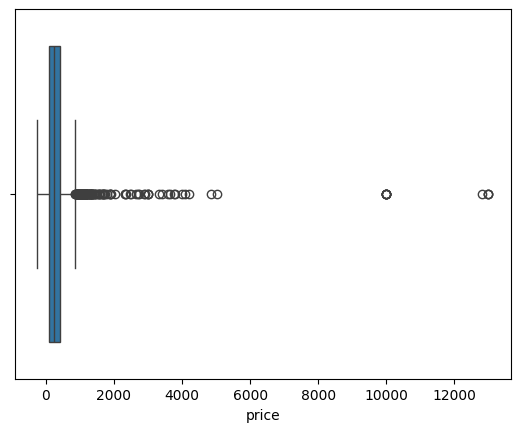

In [115]:
print("visualisasi outlier pada data:")
sns.boxplot(x=train_final['price'])

You can see that there are so many outlier in the train dataset, so we have to normalize that data using capping method in the next section

#3. PreProcessing Data

In this section, we'd like to repair data and clean data. In this data, there are so many missing values (from isnull().sum() above), and we have to clean that feature if it's missing values within 80% or more from total data. We have to find the duplicate data, outlier, and data anomalies.

**But**, before we start our preprocessing data section, we must split our data first, and drop the unused feature.

In [116]:
train_final = train_final.drop(['id', 'name', 'description', 'neighborhood_overview', 'bathrooms_text', 'host_about', 'host_neighbourhood', 'host_verifications'], axis=1)
test = testdf.drop(['id'], axis=1)

y = train_final['price']
x = train_final.drop(['price'], axis=1)

numerical_features = x.select_dtypes(include=['int', 'float']).columns
categorical_features = x.select_dtypes(include=['object']).columns

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train_raw = x_train.copy()
x_test_raw = x_test.copy()

I also add the copy of raw data, so we can use CatBoost modeling method that more accurate when using not encoded data instead of encoded.

If we look from the section above, there are so many outlier data, and there are some anomalies data (negative price), we can see that from min price above. We will assume that it's a typo, so we will use absolute to make negative value positive.

In [117]:
y_train = y_train.abs()

And for the outlier data, we will normalize the data using capping method. This method will limiting the max values for example, if we limit the price to 4000, then prices above 4000 will be converted to 4000.

To determine the upper limit and lower limit of our data, we will use the IQR method. IQR is the distance between the third quartile (Q3) and the first quartile (Q1)

$IQR = Q_3 - Q_1$

To determine our upper limit and bottom limit, we can use this method:

Upper limit formula:

$\text{Upper Limit} = Q_3 + (1.5 \cdot IQR)$


In [118]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)

IQR = Q3 - Q1
upper_limit = Q3 + (1.5 * IQR)

Change data that above than upper limit and below than lower limit

In [119]:
y_train = pd.Series(np.where(y_train > upper_limit, upper_limit, y_train), index=y_train.index)

After limitting our max prices into upper limit, now, we will drop feature that contain 50% or more missing values, and if there are some missing value, but under 50%, we will fill that with simple Imputer

In [120]:
nan_percent = x_train.isnull().mean() * 100
cols_to_drop = nan_percent[nan_percent > 50].index

x_train = x_train.drop(columns=cols_to_drop)

Import simple imputer library to use it

In [121]:
from sklearn.impute import SimpleImputer

We must redefine the numerical features and categorical features because there is a feature that got dropped while we're dropping more than 50% missing values.

And after that, we can fill the missing value with simple imputer.

In [122]:
numerical_features = x_train.select_dtypes(include=['int', 'float']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='median')
x_train[numerical_features] = imputer_num.fit_transform(x_train[numerical_features])
x_test[numerical_features] = imputer_num.transform(x_test[numerical_features])

imputer_cat = SimpleImputer(strategy='most_frequent')
x_train[categorical_features] = imputer_cat.fit_transform(x_train[categorical_features])
x_test[categorical_features] = imputer_cat.transform(x_test[categorical_features])

Next step is we will encode the categorical features into number to make the machine learning more easily. After I oberved it, I found that there are two types op categorical, single text or just only 1 sentence, and multi text, like array. So we must divide it into 2 different steps.

First is multi text feature, in this case is "amenities". We will use ast to make it converted into its base structure, and using re for cleaning unwanted character.

In [123]:
import ast
import re
from sklearn.preprocessing import MultiLabelBinarizer

x_train['amenities'] = x_train['amenities'].apply(ast.literal_eval)
x_test['amenities'] = x_test['amenities'].apply(ast.literal_eval)

def clean_amenities(lst):
    cleaned_list = []
    for item in lst:
        cleaned = re.sub(r'[^\x00-\x7F]+', '', item)
        if cleaned != '':
            cleaned_list.append(cleaned)

    return cleaned_list

x_train['amenities'] = x_train['amenities'].apply(clean_amenities)
x_test['amenities'] = x_test['amenities'].apply(clean_amenities)

mlb = MultiLabelBinarizer()
amenities_train = mlb.fit_transform(x_train['amenities'])
amenities_test = mlb.transform(x_test['amenities'])

amenities_train_df = pd.DataFrame(amenities_train, columns=mlb.classes_, index=x_train.index)
amenities_test_df = pd.DataFrame(amenities_test, columns=mlb.classes_, index=x_test.index)

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['20 inch HDTV with standard cable', '65 inch HDTV with Netflix, standard cable', '70 inch HDTV with Apple TV', 'Baby bath - available upon request', 'Biology Smart Skincare Amenities body soap', 'Biology Smart Skincare Amenities shampoo', 'Exercise equipment: free weights, stationary bike, yoga mat', 'Fast wifi  539 Mbps', 'Free driveway parking on premises  1 space', 'Free driveway parking on premises  6 spaces', 'Free parking garage on premises  1 space', 'Free parking on premises  1 space', 'HDTV with Amazon Prime Video, standard cable, Apple TV, Disney+, Netflix, Chromecast', 'HDTV with Netflix, standard cable', 'Housekeeping available from 9:00AM to 12:00PM, Sunday', 'Housekeeping available from 9:00AM to 3:00PM, 3 days a week', 'Housekeeping available from 9:30AM to 3:00AM, 3 days a week', 'Miele induction stove', 'Omno. body soap', 'Omno. shampoo', 

Merge that new encoded amenities feature into our existing train and test dataframe and drop the old one that still in categorical

In [124]:
x_train = pd.concat([x_train.drop(columns=['amenities']), amenities_train_df], axis=1)
x_test = pd.concat([x_test.drop(columns=['amenities']), amenities_test_df], axis=1)

x_train.head()

,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,instant_bookable,longitude,latitude,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_60,availability_90,availability_365,host_response_time,host_response_rate,host_acceptance_rate,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,body soap,refrigerator,shampoo,1 inch TV with Netflix,"32 inch HDTV with Netflix, standard cable, Chromecast",32 inch TV,...,Smoking allowed,Sonos Bluetooth sound system,Sound system,Sound system with Bluetooth and aux,Sound system with aux,Stainless steel double oven,Stainless steel induction stove,Stainless steel oven,Stainless steel single oven,Standalone high chair,Stove,Sun loungers,Sunsilk conditioner,Sunsilk shampoo,TV,TV with Apple TV,TV with Chromecast,"TV with HBO Max, premium cable",TV with Netflix,TV with standard cable,Table corner guards,Theme room,Toaster,Toshiba refrigerator,Toshiba refrigerator,Toshiba stainless steel oven,Trash compactor,VitaminSpa body soap,VitaminSpa conditioner,VitaminSpa shampoo,Washer,Washer In building,Washer In unit,Waterfront,Whirlpool double oven,Wifi,Wifi 41 Mbps,Window AC unit,Window guards,Wine glasses
2222,Entire serviced apartment,Entire home/apt,4.0,1.0,1.0,2.0,365.0,t,103.840122,1.295964,1.0,3.0,365.0,365.0,24.0,48.0,78.0,258.0,within an hour,97%,100%,94.0,t,River Valley,Central Region,1.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1491,Private room in rental unit,Private room,1.0,1.0,1.0,92.0,365.0,t,103.861620,1.307750,92.0,92.0,365.0,365.0,0.0,0.0,0.0,92.0,within a few hours,89%,67%,182.0,t,Kallang,Central Region,2.0,5.00,5.00,4.50,5.00,5.00,5.00,5.00,0.02,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2862,Private room in rental unit,Private room,2.0,1.0,1.0,92.0,1125.0,f,103.829510,1.293070,92.0,92.0,1125.0,1125.0,0.0,0.0,15.0,290.0,within an hour,100%,80%,3.0,t,Tanglin,Central Region,10.0,4.90,5.00,5.00,4.90,5.00,4.80,4.60,0.13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
358,Private room in rental unit,Private room,1.0,1.0,1.0,92.0,1125.0,t,103.860180,1.309630,92.0,92.0,1125.0,1125.0,27.0,57.0,87.0,362.0,within a day,60%,100%,126.0,t,Kallang,Central Region,1.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.02,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
807,Private room in rental unit,Private room,1.0,1.0,0.0,92.0,365.0,t,103.842170,1.283200,92.0,92.0,1125.0,1125.0,29.0,59.0,89.0,364.0,within an hour,67%,100%,13.0,t,Outram,Central Region,187.0,4.64,4.82,4.79,4.82,4.88,4.88,4.77,1.56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


After encoding that multi text, now we will encode that single text too using HotOneEncoder.

In [125]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = x_train.select_dtypes(include=['object']).columns.tolist()

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_train = ohe.fit_transform(x_train[categorical_columns])
ohe_test = ohe.transform(x_test[categorical_columns])

ohe_train_df = pd.DataFrame(ohe_train, columns=ohe.get_feature_names_out(categorical_columns), index=x_train.index)
ohe_test_df = pd.DataFrame(ohe_test, columns=ohe.get_feature_names_out(categorical_columns), index=x_test.index)

Merge that new encoded single text dataframe into our new final dataframe

In [126]:
numeric_columns = x_train.select_dtypes(include=['int', 'float']).columns

x_train_final = pd.concat([x_train[numeric_columns], ohe_train_df], axis=1)
x_test_final = pd.concat([x_test[numeric_columns], ohe_test_df], axis=1)

Visualization of how the feature affect the prediction of the model

<Axes: >

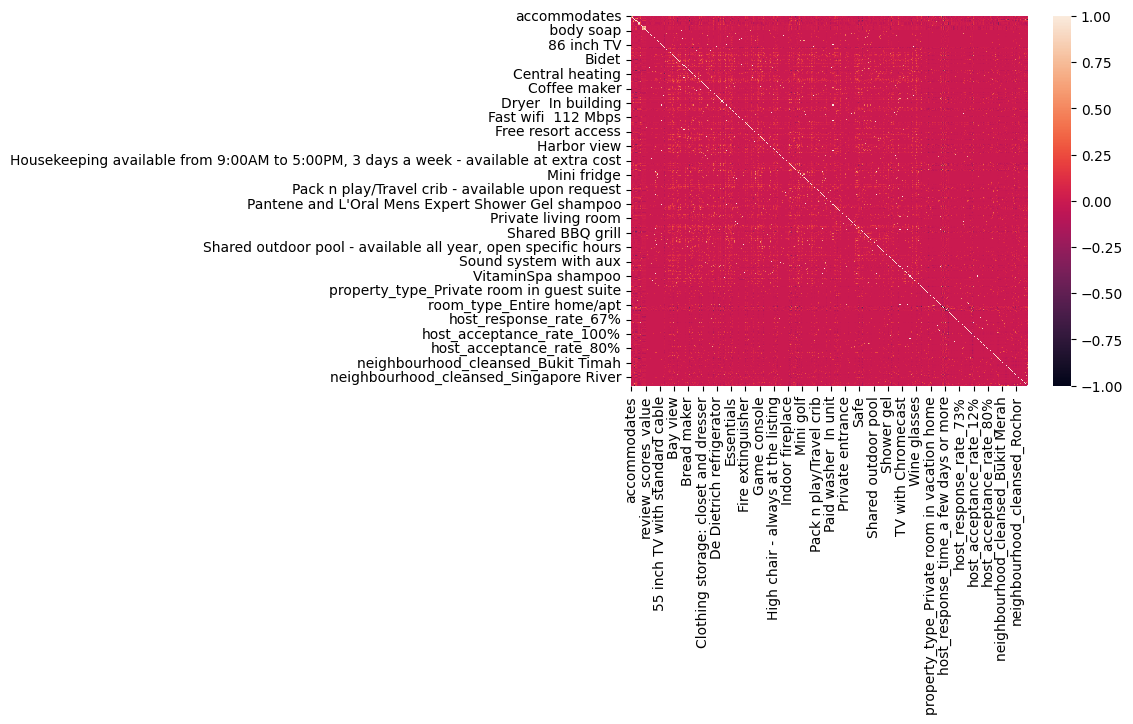

In [127]:
sns.heatmap(x_train_final.corr())

That's all for the PreProcessing step, we will continue to our next step.

#4. Modeling

In this step, this is how we train our model from dataframe that we have modifed before. In this step, we will use some models. Here, I want to use RandomForestRegressor and CatBoost. Random forest is a method that using a collection of several semantic trees. In the other hands, CatBoost works by managing categorical variables natively, without requiring complex data preprocessing such as one-hot encoding which is often required by other decision tree-based algorithms.

**a. Catboost Regressor**

Import catboost regressor first, and then you can use it.

In [128]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

Start modeling with catboost.

In [129]:
cb_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

print("Training data menggunakan CatBoost")

object_cols_raw_train = x_train_raw.select_dtypes(include='object').columns

for col in object_cols_raw_train:
    x_train_raw[col] = x_train_raw[col].fillna('Unknown').astype(str)
    x_test_raw[col] = x_test_raw[col].fillna('Unknown').astype(str)

categorical_features_for_catboost = x_train_raw.select_dtypes(include=['object']).columns.tolist()

cb_model.fit(x_train_raw, y_train, cat_features=categorical_features_for_catboost, eval_set=(x_test_raw, y_test), early_stopping_rounds=50)

y_pred_cb = cb_model.predict(x_test_raw)

Training data menggunakan CatBoost
0:	learn: 228.2265137	test: 560.3425684	best: 560.3425684 (0)	total: 20.2ms	remaining: 20.1s
100:	learn: 124.2656828	test: 501.5624986	best: 501.5034848 (97)	total: 2.33s	remaining: 20.7s
200:	learn: 110.9944878	test: 494.7272772	best: 494.7225784 (199)	total: 4.53s	remaining: 18s
300:	learn: 101.9731871	test: 490.8948867	best: 490.8948867 (300)	total: 6.78s	remaining: 15.7s
400:	learn: 95.5448977	test: 488.4331960	best: 488.4185866 (398)	total: 9.03s	remaining: 13.5s
500:	learn: 89.5809216	test: 486.6475032	best: 486.5900020 (498)	total: 11.2s	remaining: 11.2s
600:	learn: 84.2281786	test: 485.3039201	best: 485.3039201 (600)	total: 13.5s	remaining: 8.93s
700:	learn: 80.2749246	test: 484.5775733	best: 484.5775733 (700)	total: 15.7s	remaining: 6.69s
800:	learn: 76.7762335	test: 483.7584937	best: 483.7584937 (800)	total: 17.9s	remaining: 4.44s
900:	learn: 73.6467939	test: 483.3138025	best: 483.3091141 (898)	total: 20.1s	remaining: 2.21s
999:	learn: 71.49

**b. Random Forest Regressor**

First thing to do is import model sklearn. I'm using GridSearch to find best combination of parameters.

In [130]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

print("Searching for best paramerets")
grid_search.fit(x_train_final, y_train)

Searching for best paramerets
Fitting 3 folds for each of 36 candidates, totalling 108 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 15, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [100, 200, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


Save the best parameter into a variabel

In [131]:
print("\nParameter Terbaik:", grid_search.best_params_)
print("Skor Terbaik (MSE rata-rata):", -grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(x_test_final)


Parameter Terbaik: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Skor Terbaik (MSE rata-rata): 16908.688178410204


#5. Model Evaluation

In this last of our section, we're gonna evaluate the model that we have used to predict. Here, we will calculate the error of our models using sklearn.metrics method. I'm using Mean Absolute Error (MEA), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and the r2_score methods.

Import first and then use it

In [132]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def model_evaluation(model_name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return [model_name, mae, mse, rmse]

hasil_cb = model_evaluation("CatBoost Regressor", y_test, y_pred_cb)
hasil_rf = model_evaluation("Random Forest Regressor", y_test, y_pred_rf)

And after that error comparisor between two models, we have to decide, which model has less error number. We use dataframe and visualization to finding the best models.


Model Evaluation Comparison:
                     Model         MAE            MSE        RMSE
0       CatBoost Regressor  119.772061  233244.229484  482.953651
1  Random Forest Regressor  121.573493  239668.253717  489.559244


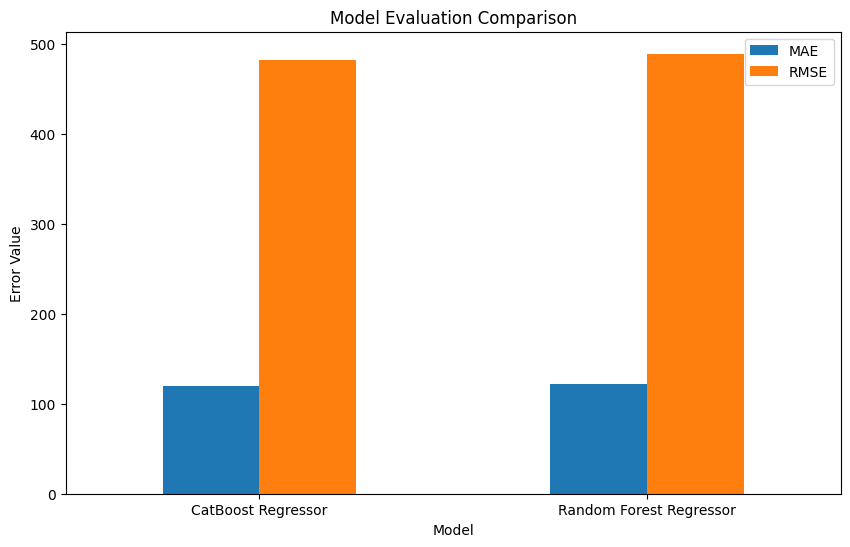

In [133]:
df_eval = pd.DataFrame([hasil_cb, hasil_rf], columns=['Model', 'MAE', 'MSE', 'RMSE'])

print("\nModel Evaluation Comparison:")
print(df_eval)

df_eval.plot(x='Model', y=['MAE', 'RMSE'], kind='bar', figsize=(10, 6))
plt.title('Model Evaluation Comparison')
plt.ylabel('Error Value')
plt.xticks(rotation=0)
plt.show()

As you can see, the CatBoost model is better than RandomForestRegresson in this case. The CatBoost model metrics is all higher than RandomForestRegressor. So we will use the prediction from CatBoost for the submission of our prediction.

We must merge all the data with its each feature to predict the price, so we'll have to merge and simple preprocessing again like we do at the beginning of this notebook.

In [134]:
df_test_ids = pd.read_csv('sample_data/test.csv')
df_airbnb = pd.read_csv('sample_data/airbnb.csv')
df_host = pd.read_csv('sample_data/host.csv')
df_review = pd.read_csv('sample_data/review.csv')

test_merged1 = pd.merge(df_test_ids, df_airbnb, on='id', how='left')
test_merged2 = pd.merge(test_merged1, df_host, on='id', how='left')
test_final = pd.merge(test_merged2, df_review, on='id', how='left')

test_prep = test_final.drop(['id', 'name', 'description', 'neighborhood_overview', 'bathrooms_text', 'host_about', 'host_neighbourhood', 'host_verifications'], axis=1)

required_columns = cb_model.feature_names_
test_prep = test_prep[required_columns]

cat_features = test_prep.select_dtypes(include=['object']).columns
for col in cat_features:
    test_prep[col] = test_prep[col].fillna('Unknown').astype(str)

num_features = test_prep.select_dtypes(include=['int', 'float']).columns
for col in num_features:
    median_value = train_final[col].median()
    test_prep[col] = test_prep[col].fillna(median_value)

To submit the prediction, we will predict the test dataset first, merge the id from our backup and convert that into csv

In [137]:
y_pred_final = cb_model.predict(test_prep)

submission = pd.DataFrame({
    'id': test_id,
    'price': y_pred_final
})

submission.head()

submission.to_csv("sample_data/submission/submission1.csv", index=False)